In [2]:
import json
import pickle
import logging 
import os
import warnings

import joblib
import mlflow
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, precision_recall_fscore_support, 
                             precision_score, recall_score, roc_auc_score)

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

warnings.filterwarnings("ignore")

### Model building baseline with mlflow tracking

In [3]:
def read_csv(file_name: str, path="data/data_processed") -> pd.DataFrame:
    """
    Read csv file
    Args:
        file_name: str,
        path_:str
    Returns:
        pd.DataFrame
    """
    return pd.read_csv(os.path.join(path, file_name))

In [5]:
df_tickets = read_csv("tickets_inputs_eng_1.csv")

In [8]:
df_tickets.head()

,complaint_what_happened,ticket_classification,processed_text,relevant_topics
0,Good morning my name is XXXX XXXX and I apprec...,Debt collection + Credit card debt,morning nam bank cardmemb servic i debt verifi...,Mortgage/Loan
1,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card + General-purpose ...,i card agent upgrad dat agent information orde...,Mortgage/Loan
2,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",card report howev application hav identity con...,Mortgage/Loan
3,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",book ticket offer ticket card i information of...,Mortgage/Loan
4,my grand son give me check for {$1600.00} i de...,Checking or savings account + Checking account,giv check deposit chas account fund cle bank c...,Bank Account Services


In [9]:
df_tickets.shape

(18957, 4)

In [12]:
df_tickets.relevant_topics.value_counts() #contamos ls etiquetas disponibles

relevant_topics
Mortgage/Loan                    16648
Bank Account Services             2132
Credit Report or Prepaid Card      177
Name: count, dtype: int64

In [16]:
#realizamos un set tracking uri

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("tickets_baseline")


def data_transform(df: pd.DataFrame):
    """This function transform the data into X and y
    Args:
      df (pd.DataFrame): dataframe with the data
    Returns:
      X (pd.Series): series with the text
      y (pd.Series): series with the labels"""
    X = df["processed_text"]
    y = df["relevant_topics"]

    return X, y


def read_idx2label(json_path: str) -> pd.Series:
    """This function read the json file and return a dictionary
    Args:
      json_path (str): path to the json file
     Returns:
      idx2label (dict): dictionary with the mapping"""
    with open(json_path) as f:
        idx2label = json.load(f)
    return idx2label


def decode_labels_into_idx(labels: pd.Series, idx2label: dict) -> pd.Series:
    """This function decode the labels into idx
    Args:
      labels (pd.Series): series with the labels
      idx2label (dict): dictionary with the mapping
     Returns:
      labels (pd.Series): series with the labels decoded
    """
    return labels.map(idx2label)


def fit_transform(X: pd.Series) -> np.ndarray:
    count_vectorizer = CountVectorizer()
    X_vectorized = count_vectorizer.fit_transform(X)
    #save count vectorizer for data preprocessing in the main app (deploy)
    joblib.dump(count_vectorizer, 'data/data_processed/count_vectorizer.pkl')
    logger.info("count vectorizer trained successfully stored")
    return X_vectorized


def transform_tfidf(X_vectorized: object) -> np.ndarray:
    tfidf_transformer = TfidfTransformer()
    X_tfidf = tfidf_transformer.fit_transform(X_vectorized)
    joblib.dump(X_tfidf, 'data/data_processed/X_tfidf.pkl')
    logger.info("X_tfidf trained successfully stored")
    return X_tfidf

def split_train_test(
    X_tfidf: np.array, y: pd.Series, test_size: float = 0.3, random_state: int = 42
) -> tuple:
    """This function split the data into train and test
    Args:
      X_tfidf (np.array): array with the vectorized data
      y (pd.Series): series with the labels
      test_size (float): test size
      random_state (int): random state
     Returns:
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def display_classification_report(
    model: object,
    name_model: str,
    developer: str,
    X_train: np.array,
    X_test: np.array,
    y_train: np.array,
    y_test: np.array,
    use_cv = False
):
    """This function display the classification report
    Args:
      model (object): model
      X_train (np.array): array with the vectorized data for train
      X_test (np.array): array with the vectorized data for test
      y_train (pd.Series): series with the labels for train
      y_test (pd.Series): series with the labels for test
     Returns:
      metric (list): list with the metrics"""

    with mlflow.start_run(run_name=name_model):
        mlflow.log_param("model", name_model)
        mlflow.log_param("developer", developer)

        metric = []
        y_train_pred_proba = model.predict_proba(X_train)
        y_test_pred_proba = model.predict_proba(X_test)
        roc_auc_score_train = round(
            roc_auc_score(
                y_train, y_train_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )
        roc_auc_score_test = round(
            roc_auc_score(
                y_test, y_test_pred_proba, average="weighted", multi_class="ovr"
            ),
            2,
        )

        print("ROC AUC Score Train:", roc_auc_score_train)
        print("ROC AUC Score Test:", roc_auc_score_test)
        metric.extend([roc_auc_score_train, roc_auc_score_test])

        mlflow.log_metric("roc_auc_train", roc_auc_score_train)
        mlflow.log_metric("roc_auc_test", roc_auc_score_test)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        (
            precision_train,
            recall_train,
            fscore_train,
            support_train,
        ) = precision_recall_fscore_support(y_train, y_train_pred, average="weighted")
        (
            precision_test,
            recall_test,
            fscore_test,
            support_test,
        ) = precision_recall_fscore_support(y_test, y_test_pred, average="weighted")

        mlflow.log_metric("precision_train", precision_train)
        mlflow.log_metric("precision_test", precision_test)
        mlflow.log_metric("recall_train", recall_train)
        mlflow.log_metric("recall_test", recall_test)
        
        try:
            if use_cv:
                best_params = model.best_params_
            else:
                best_params = model.get_params()
            mlflow.log_params(best_params)

        except AttributeError as e:
            print(f"Error: {e}")


        acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
        acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)

        metric.extend(
            [
                acc_score_train,
                acc_score_test,
                round(precision_train, 2),
                round(precision_test, 2),
                round(recall_train, 2),
                round(recall_test, 2),
                round(fscore_train, 2),
                round(fscore_test, 2),
            ]
        )

        print("Train Accuracy: ", acc_score_train)
        print("Test Accuracy: ", acc_score_test)

        model_report_train = classification_report(y_train, y_train_pred)
        model_report_test = classification_report(y_test, y_test_pred)

        print("Classification Report for Train:\n", model_report_train)
        print("Classification Report for Test:\n", model_report_test)

        # Plot the confusion matrix
        fig, ax = plt.subplots(figsize=(12, 8))

        # Create the confusion matrix with labels decoded
        decoded_y_test_pred = [idx2label[idx] for idx in y_test_pred]
        decoded_y_test = [idx2label[idx] for idx in y_test]

        cm = confusion_matrix(decoded_y_test, decoded_y_test_pred)
        cmp = ConfusionMatrixDisplay(cm, display_labels=list(idx2label.values()))
        cmp.plot(ax=ax)

        plt.xticks(rotation=80)
        plt.show()

        mlflow.sklearn.log_model(model, f"models/{name_model}")

        return metric


def grid_search(model, folds, params, scoring):
    """This function perform a grid search
    Args:
        model (object): model
        folds (int): number of folds
        params (dict): dictionary with the parameters
        scoring (str): scoring
    Returns:
        grid_search (object): grid search
    """

    grid_search = GridSearchCV(
        model, cv=folds, param_grid=params, scoring=scoring, n_jobs=-1, verbose=1
    )
    return grid_search


def print_best_score_params(model):
    """This functions print best score and best hyperparameters for baselines models
    Args:
        model (object): model
    Returns:
        None"""
    print("Best Score: ", model.best_score_)
    print("Best Hyperparameters: ", model.best_params_)


In [17]:
idx2label = read_idx2label(json_path="data/data_processed/topic_mapping_1.json")
label2idx = {value: key for key, value in idx2label.items()}

X, y = data_transform(df_tickets)
y = decode_labels_into_idx(labels=y, idx2label=label2idx)

X_vectorized = fit_transform(X.values)
X_tfidf = transform_tfidf(X_vectorized)
X_train, X_test, y_train, y_test = split_train_test(X_tfidf, y)

## Modelo Multinomial Naive Bayes

ROC AUC Score Train: 0.62
ROC AUC Score Test: 0.53
Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.40      0.33      0.31     13269
weighted avg       0.81      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.29      0.33      0.31      5688
weighted avg       0.77      0.88      0.82      5688



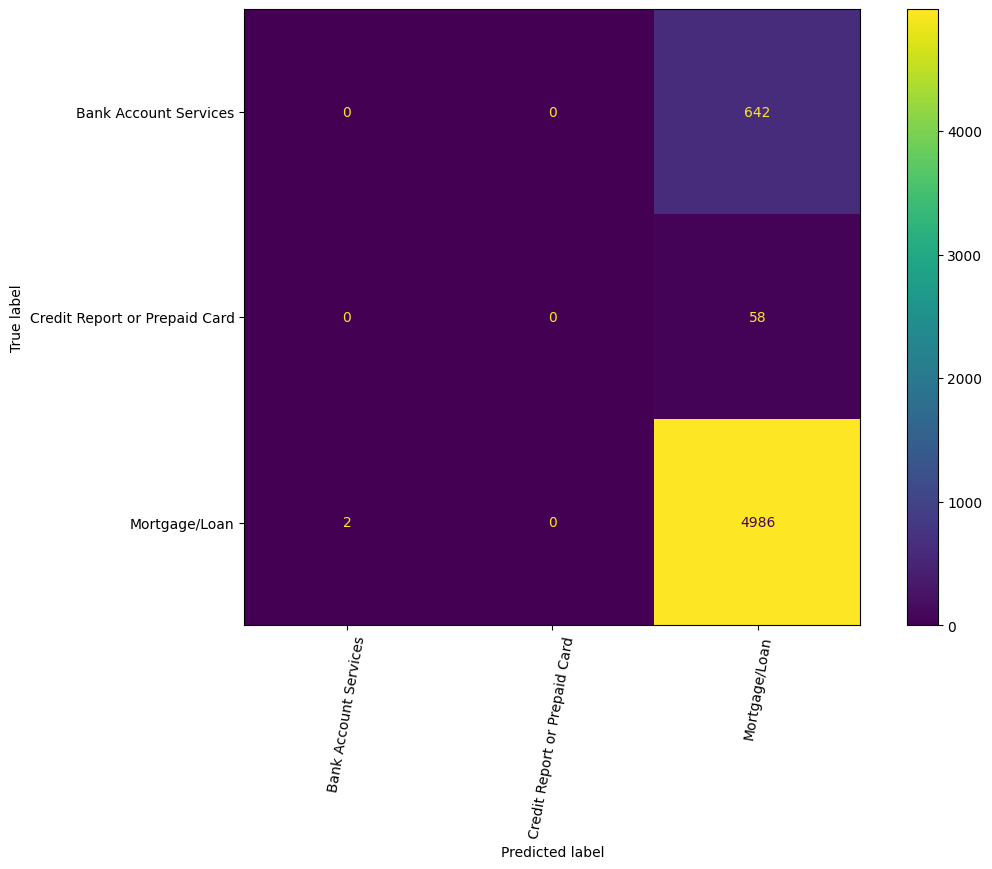

[0.62, 0.53, 0.88, 0.88, 0.81, 0.77, 0.88, 0.88, 0.82, 0.82]

In [18]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
display_classification_report(model=mnb, 
                              name_model="MultinomialNB", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test)

## Modelo  multinomial Naive Bayes con GreadSearch

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score:  0.8785891957775688
Best Hyperparameters:  {'alpha': 1}
ROC AUC Score Train: 0.62
ROC AUC Score Test: 0.53
Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.33      0.00      0.00      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.40      0.33      0.31     13269
weighted avg       0.81      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.29      0.33      0.31      5688
weig

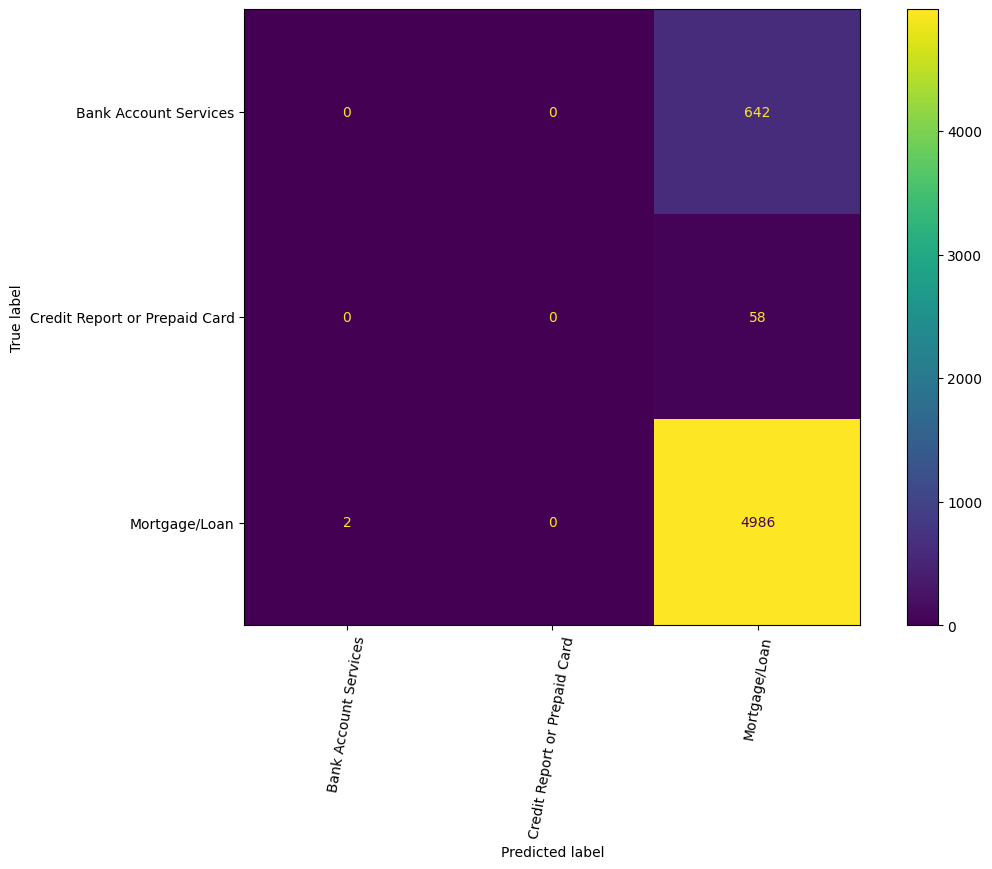

[0.62, 0.53, 0.88, 0.88, 0.81, 0.77, 0.88, 0.88, 0.82, 0.82]

In [19]:
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 40)
mnb = MultinomialNB()
mnb_params = {  
'alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
}
grid_search_mnb = grid_search(mnb, folds, mnb_params, scoring=None)
grid_search_mnb.fit(X_train, y_train)
print_best_score_params(grid_search_mnb)

display_classification_report(model=grid_search_mnb, 
                              name_model="MultinomialNBCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv= True)

## Logistic Regression

ROC AUC Score Train: 0.82
ROC AUC Score Test: 0.62
Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.81      0.01      0.02      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.56      0.34      0.32     13269
weighted avg       0.86      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.17      0.00      0.01       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.35      0.33      0.31      5688
weighted avg       0.79      0.88      0.82      5688



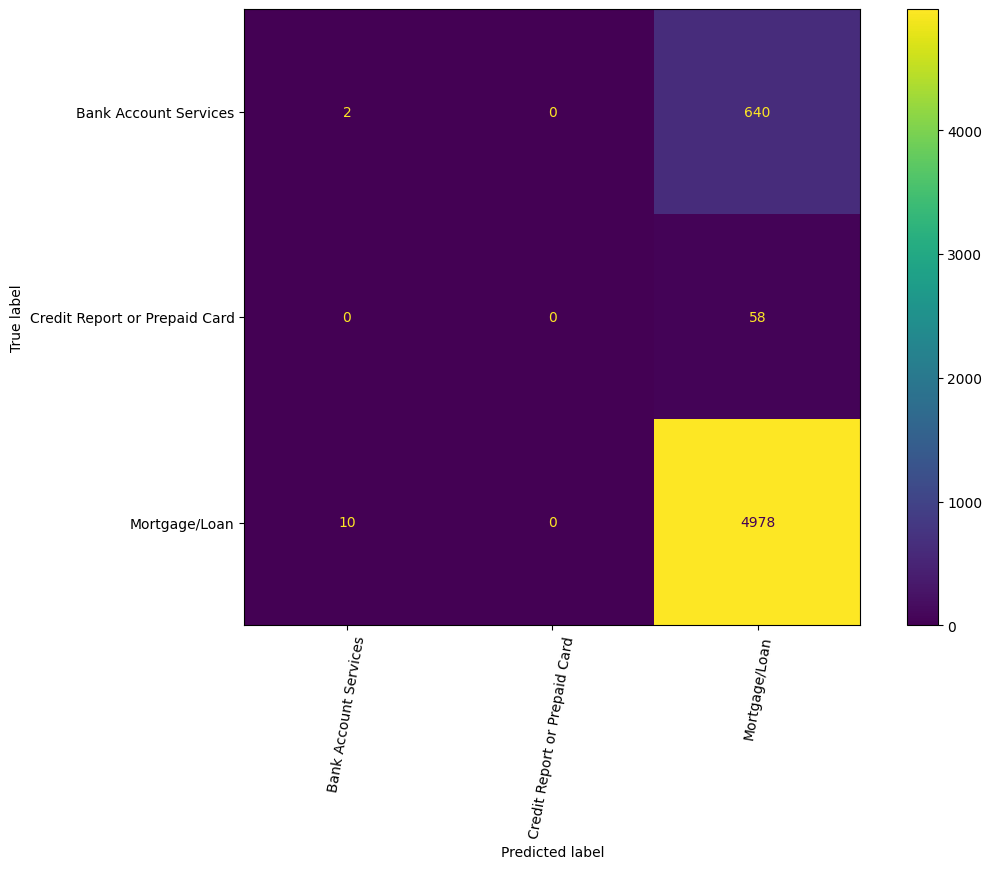

[0.82, 0.62, 0.88, 0.88, 0.86, 0.79, 0.88, 0.88, 0.82, 0.82]

In [20]:
log_reg = LogisticRegression(random_state=40,solver='liblinear')
log_reg.fit(X_train,y_train)
display_classification_report(model=log_reg, 
                              name_model="LogisticRegression", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=False)

## Logistic Regression With GreadSearch

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Score:  0.8787399400829022
Best Hyperparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
ROC AUC Score Train: 0.5
ROC AUC Score Test: 0.5
Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.29      0.33      0.31     13269
weighted avg       0.77      0.88      0.82     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0

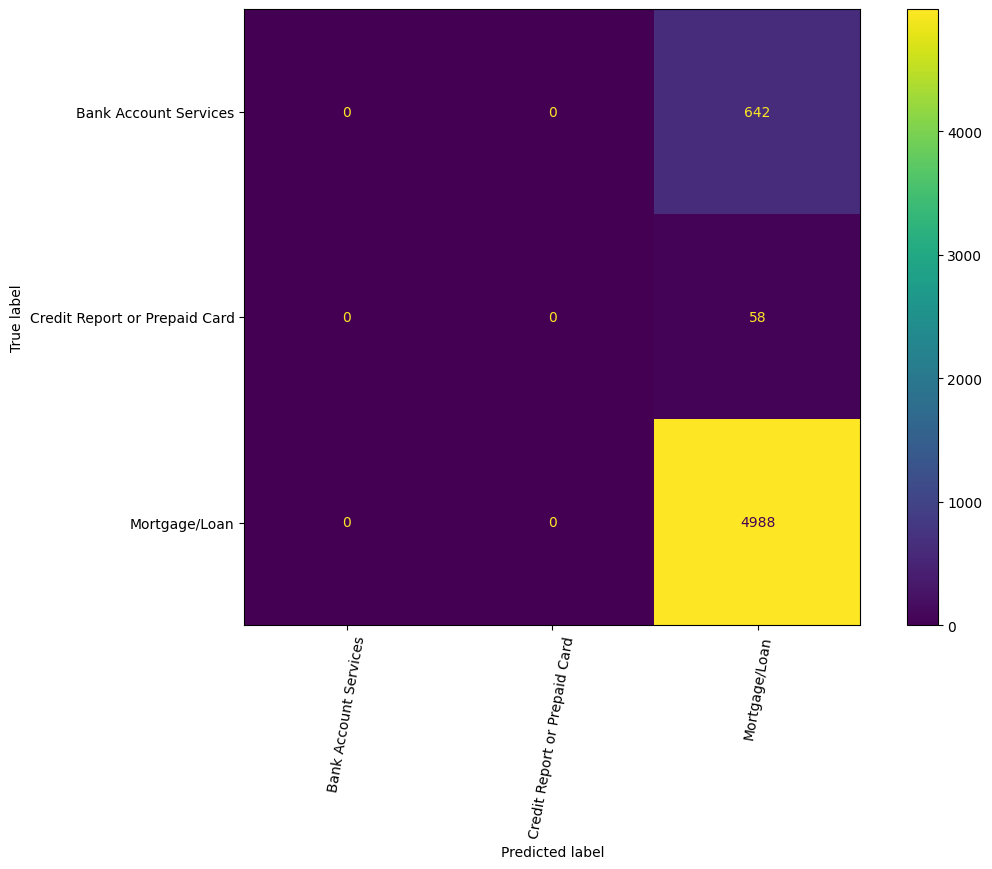

[0.5, 0.5, 0.88, 0.88, 0.77, 0.77, 0.88, 0.88, 0.82, 0.82]

In [21]:
log_reg = LogisticRegression()
log_params = {'C': [0.01, 1, 10], 
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear','newton-cg','saga']
         }
grid_search_log = grid_search(log_reg, folds, log_params, scoring=None)
grid_search_log.fit(X_train, y_train)
print_best_score_params(grid_search_log)
display_classification_report(grid_search_log,
                              name_model="LogisticRegressionCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

## Decision Tree Classifier

ROC AUC Score Train: 1.0
ROC AUC Score Test: 0.53
Train Accuracy:  1.0
Test Accuracy:  0.81
Classification Report for Train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1490
           1       1.00      1.00      1.00       119
           2       1.00      1.00      1.00     11660

    accuracy                           1.00     13269
   macro avg       1.00      1.00      1.00     13269
weighted avg       1.00      1.00      1.00     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.18      0.15      0.16       642
           1       0.03      0.02      0.02        58
           2       0.88      0.91      0.90      4988

    accuracy                           0.81      5688
   macro avg       0.36      0.36      0.36      5688
weighted avg       0.80      0.81      0.80      5688



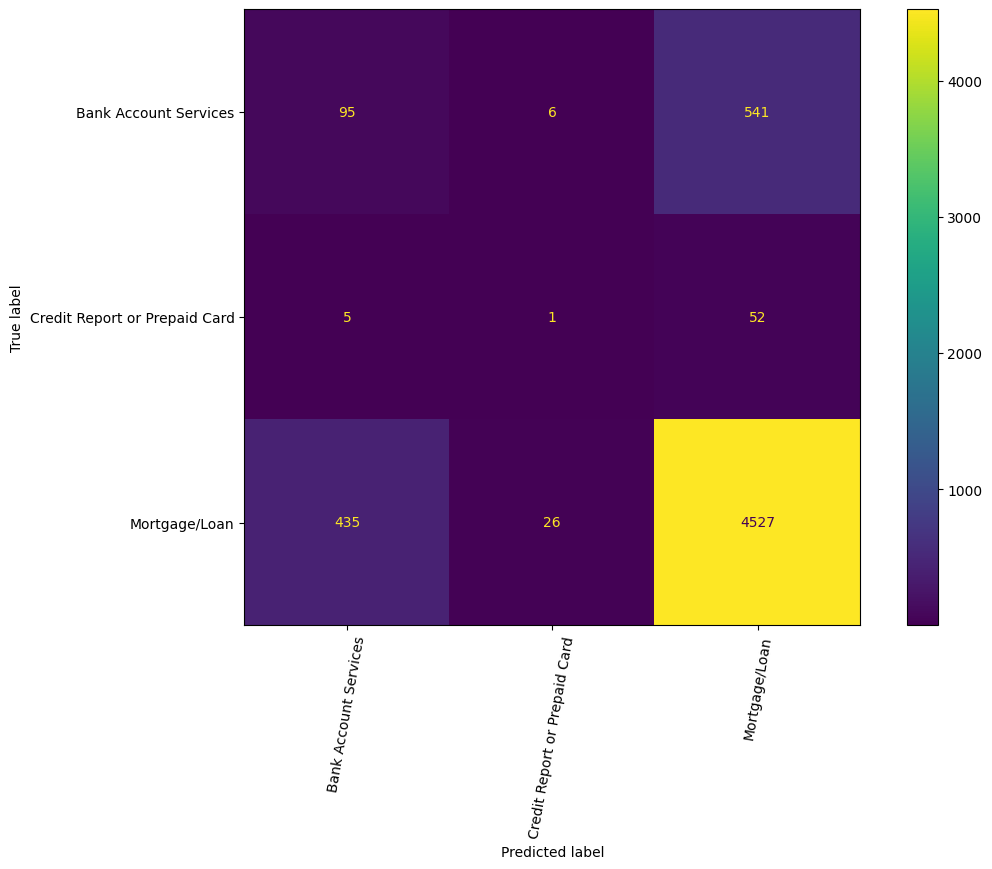

[1.0, 0.53, 1.0, 0.81, 1.0, 0.8, 1.0, 0.81, 1.0, 0.8]

In [22]:
dtc = DecisionTreeClassifier(random_state=40)
dtc.fit(X_train,y_train)
display_classification_report(model=dtc,
                              name_model="DecisionTreeClassifier",
                              developer="Maria",
                              X_train=X_train,
                              X_test=X_test,
                              y_train=y_train,
                              y_test=y_test,
                              use_cv=False)

## Decision Tree Classifier with Gread Search

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Score:  0.56255949362839
Best Hyperparameters:  {'max_depth': 4, 'min_samples_leaf': 3}
ROC AUC Score Train: 0.59
ROC AUC Score Test: 0.56
Train Accuracy:  0.88
Test Accuracy:  0.88
Classification Report for Train:
               precision    recall  f1-score   support

           0       0.76      0.03      0.06      1490
           1       0.00      0.00      0.00       119
           2       0.88      1.00      0.94     11660

    accuracy                           0.88     13269
   macro avg       0.55      0.34      0.33     13269
weighted avg       0.86      0.88      0.83     13269

Classification Report for Test:
               precision    recall  f1-score   support

           0       0.25      0.01      0.01       642
           1       0.00      0.00      0.00        58
           2       0.88      1.00      0.93      4988

    accuracy                           0.88      5688
   macro avg       0.38      0.3

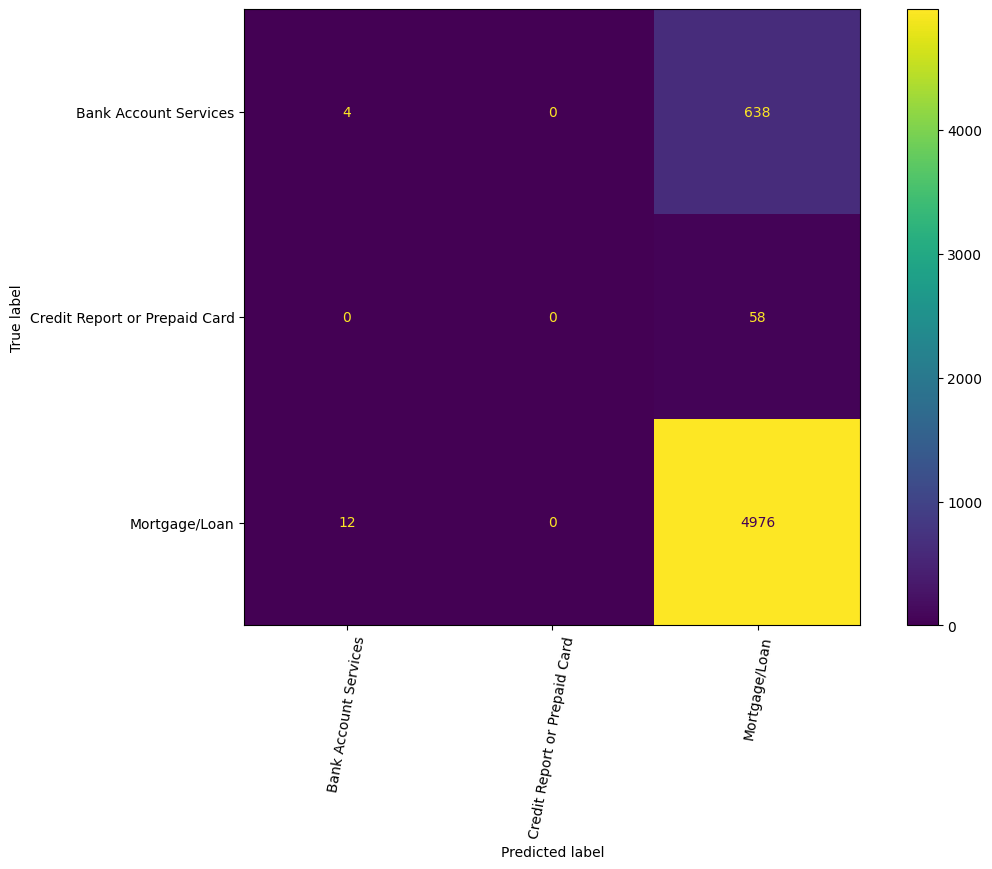

[0.59, 0.56, 0.88, 0.88, 0.86, 0.8, 0.88, 0.88, 0.83, 0.82]

In [23]:
# decis|on tree classifier with grid search
dtc_cv = DecisionTreeClassifier(random_state=40)
dtc_params = {
    'max_depth': [2,3,4,5],
    'min_samples_leaf': [2,3,4,7]
}

grid_search_dtc = grid_search(dtc_cv, folds, dtc_params, scoring='roc_auc_ovr')
grid_search_dtc.fit(X_train, y_train)
print_best_score_params(grid_search_dtc)
display_classification_report(grid_search_dtc, 
                              name_model="DecisionTreeClassifierCV", 
                              developer="Maria", 
                              X_train=X_train, 
                              X_test=X_test, 
                              y_train=y_train, 
                              y_test=y_test, 
                              use_cv=True)

Hacer mlflow ui --backend-store-uri sqlite:///mlflow.db

## Hacer inferencias con el modelo 

In [24]:
logged_model = 'runs:/2310c35e7c974dd680f8b3696da1869e/models/LogisticRegression'
# load model as a PyFuncModel
loaded_model = mlflow.pyfunc.load_model(logged_model
                                        )

In [25]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models/LogisticRegression
  flavor: mlflow.sklearn
  run_id: 2310c35e7c974dd680f8b3696da1869e

In [26]:
assert X_train.toarray().shape[0] == y_train.shape[0]

In [27]:
lr_model = mlflow.sklearn.load_model(logged_model)

In [28]:
lr_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 40,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
lr_model.predict(X_test)

array(['2', '2', '2', ..., '2', '2', '2'], dtype=object)

In [30]:
from mlflow.tracking import MlflowClient
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [31]:
runs = mlflow.search_runs()
# Extrae los IDs únicos de los experimentos
experiment_ids = runs['experiment_id'].unique()

In [32]:
experiment_ids


array(['1'], dtype=object)

In [33]:
client.create_experiment("regression_models")

'2'

In [34]:
runs = client.search_runs(experiment_ids=["1"])
for run in runs:
    print(run.info)

<RunInfo: artifact_uri='/home/jam/Mlops-platzi/tracking/mlruns/1/ebe3b42f4d574d9e83fa8da6b6ece768/artifacts', end_time=1724022237333, experiment_id='1', lifecycle_stage='active', run_id='ebe3b42f4d574d9e83fa8da6b6ece768', run_name='DecisionTreeClassifierCV', run_uuid='ebe3b42f4d574d9e83fa8da6b6ece768', start_time=1724022232987, status='FINISHED', user_id='jam'>
<RunInfo: artifact_uri='/home/jam/Mlops-platzi/tracking/mlruns/1/8f291b89abaf4f809c60f83ecd58dd58/artifacts', end_time=1724022134185, experiment_id='1', lifecycle_stage='active', run_id='8f291b89abaf4f809c60f83ecd58dd58', run_name='DecisionTreeClassifier', run_uuid='8f291b89abaf4f809c60f83ecd58dd58', start_time=1724022129279, status='FINISHED', user_id='jam'>
<RunInfo: artifact_uri='/home/jam/Mlops-platzi/tracking/mlruns/1/c9244e20c68740d4b2a37999606b320c/artifacts', end_time=1724021519882, experiment_id='1', lifecycle_stage='active', run_id='c9244e20c68740d4b2a37999606b320c', run_name='LogisticRegressionCV', run_uuid='c9244e20c